In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext scalene

from Optimizer import *
from SlippageModel import average_slippage_model_vectorized, average_slippage_model_cvxpy

import pandas as pd
import numpy as np

import sys
import os

import optuna

# Absolute or relative path to your library
lib_path = os.path.abspath("/home/ubuntu/git/Baus-Research/")

# Add to sys.path
if lib_path not in sys.path:
    sys.path.append(lib_path)

from src.baus_utils.data_utils import get_tardis_files
from src.baus_utils.system_utils import log_message

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [3]:
# In-Samples
#"2022-02-01"-"2022-06-01"
#"2022-11-01"-"2023-05-01"
#"2024-01-01"-"2024-06-01"

start_date = pd.Timestamp("2022-11-01")
start_date_hourly_returns = pd.Timestamp("2022-10-01")
end_date = pd.Timestamp("2023-05-01")

In [4]:
predicted_returns = pd.read_parquet("forecasts_v4.parquet").set_index("timestamp")
predicted_returns = predicted_returns.loc[start_date:end_date]

unique_coins = predicted_returns.TICKER.unique()

predicted_returns = predicted_returns.iloc[len(unique_coins):].fillna(0)
predicted_returns = predicted_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [5]:
resid_returns = pd.read_parquet("resid_returns_top50.parquet.gz").set_index("timestamp")
resid_returns = resid_returns.loc[start_date_hourly_returns:end_date]
resid_returns = resid_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER")).fillna(0)

In [6]:
factors = pd.read_parquet("risk_factor_loadings.parquet.gz").set_index("timestamp")
factors = factors.loc[start_date_hourly_returns:end_date].fillna(0)

exposure_columns = [column_name for column_name in factors.columns if "exposure" in column_name]
return_columns = [column_name for column_name in factors.columns if "returns" in column_name]

factor_exposures = factors[exposure_columns + ["TICKER"]].fillna(0)
factor_returns = factors[return_columns]
factor_returns = factor_returns.groupby(factor_returns.index).tail(1).fillna(0)

factor_exposures = factor_exposures.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [7]:
betas = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["beta_clip", "TICKER"]].fillna(0)
index_prices = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["index_price", "TICKER"]].fillna(0)

betas = betas.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))
index_prices = index_prices.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [9]:
coin_specs = {}
volumes = pd.DataFrame()
for coin in unique_coins:
    print(coin)
    temp_data = get_tardis_files(start_date_hourly_returns, end_date, 'trades', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    volumes[coin] = temp_data["volume"].rolling(24).sum() * temp_data["close"]
    price_str = str(temp_data["close"].iloc[-1])
    digits = len(price_str.split(".")[1])
    increment = round(0.1**digits, digits)
    coin_specs[coin] = (digits, increment)

volumes = volumes.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="volume").set_index("timestamp")

1000LUNC
1000SHIB
ADA
APE
ATOM
AVAX
AXS
BNB
CHZ
CRV
DOGE
DOT
ENS
EOS
ETC
ETH
FIL
GMT
KLAY
LINK
LIT
LTC
LUNA2
MASK
MATIC
NEAR
OP
REEF
RSR
SOL
SUSHI
XRP
DYDX
SAND
BAND
GALA
FTT
FTM
PEOPLE
ALGO
APT
SFP
TRX
BNX
WAVES
RLC
OCEAN
LDO
MANA
GRT
FET
AUDIO
STG
HOOK
DUSK
INJ
MAGIC
ANKR
NEO
MINA
YFI
AGIX
MKR
SNX
CFX
STX
IMX
LINA
REN
SXP
TRU
LQTY
ICX
OMG
ARB
ID
CTSI
RNDR
COCOS


In [ ]:
funding_rates = pd.DataFrame()
for coin in unique_coins:
    funding = get_tardis_files(start_date, end_date, 'derivative_ticker', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    funding.loc[funding.index != funding["funding_timestamp"], "funding_rate"] = 0
    funding = funding["funding_rate"]
    funding_rates[coin] = funding
funding_rates = funding_rates.fillna(0)
funding_rates = funding_rates.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="funding_rate").set_index("timestamp")

In [25]:
liquidity = pd.read_csv("LiquidityDataCombined.csv").set_index("date")[["TICKER", "spread"]]
liquidity.index = pd.to_datetime(liquidity.index)

In [11]:
recovery_rate = 0.9

mean_error_df = index_prices.copy()
mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
mean_error_df = mean_error_df[["TICKER", "return"]]

mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                             np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                             np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)

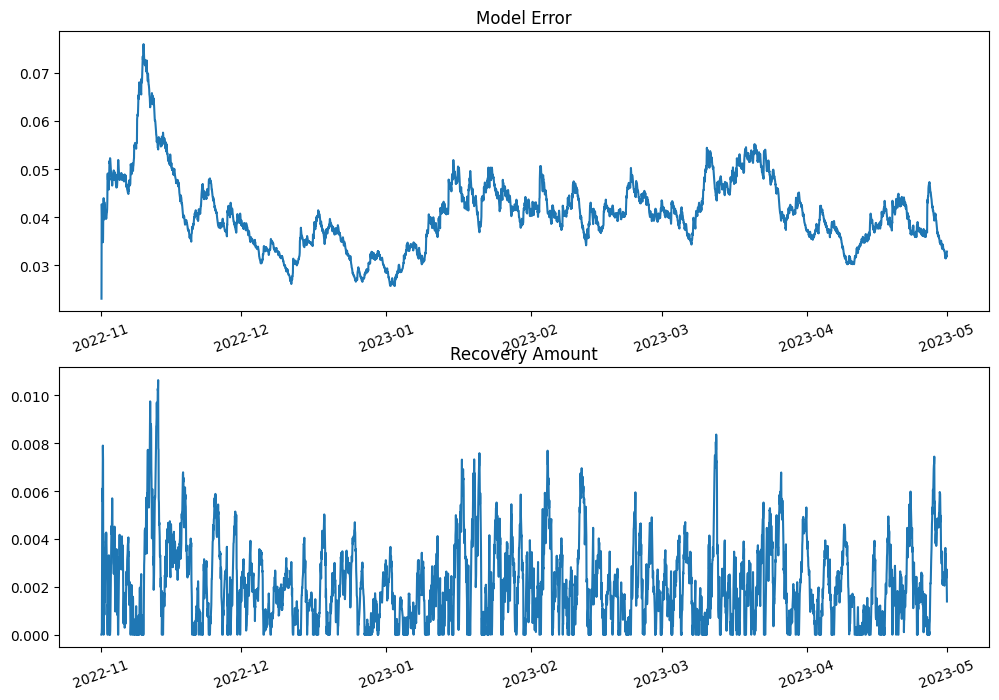

In [12]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(recovery_amt)
axis[1].set_title("Recovery Amount")
axis[1].tick_params(axis='x', rotation=20)

plt.show()

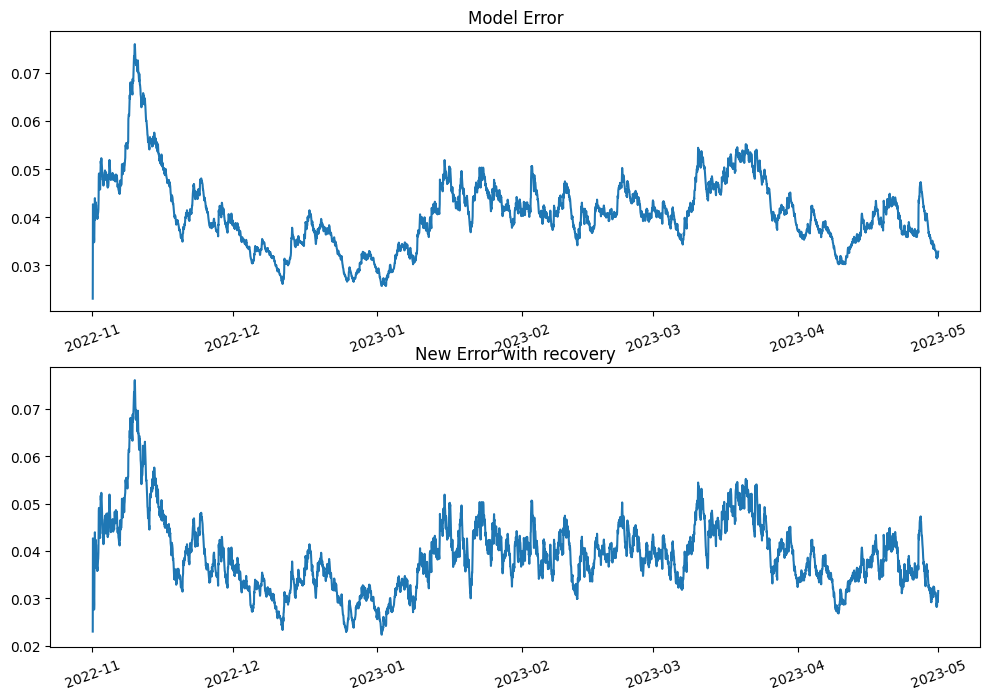

In [13]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(new_error)
axis[1].set_title("New Error with recovery")
axis[1].tick_params(axis='x', rotation=20)


plt.show()

In [29]:
import warnings
warnings.filterwarnings("ignore")

2022-11-01 02:00:00
2022-11-01 03:00:00
2022-11-01 04:00:00
2022-11-01 05:00:00
2022-11-01 06:00:00
2022-11-01 07:00:00
2022-11-01 08:00:00
2022-11-01 09:00:00
2022-11-01 10:00:00
2022-11-01 11:00:00
2022-11-01 12:00:00
2022-11-01 13:00:00
2022-11-01 14:00:00
2022-11-01 15:00:00
2022-11-01 16:00:00
2022-11-01 17:00:00
2022-11-01 18:00:00
2022-11-01 19:00:00
2022-11-01 20:00:00
2022-11-01 21:00:00
2022-11-01 22:00:00
2022-11-01 23:00:00
2022-11-02 00:00:00
2022-11-02 01:00:00
2022-11-02 02:00:00
2022-11-02 03:00:00
2022-11-02 04:00:00
2022-11-02 05:00:00
2022-11-02 06:00:00
2022-11-02 07:00:00
2022-11-02 08:00:00
2022-11-02 09:00:00
2022-11-02 10:00:00
2022-11-02 11:00:00
2022-11-02 12:00:00
2022-11-02 13:00:00
2022-11-02 14:00:00
2022-11-02 15:00:00
2022-11-02 16:00:00
2022-11-02 17:00:00
2022-11-02 18:00:00
2022-11-02 19:00:00
2022-11-02 20:00:00
2022-11-02 21:00:00
2022-11-02 22:00:00
2022-11-02 23:00:00
2022-11-03 00:00:00
2022-11-03 01:00:00
2022-11-03 02:00:00
2022-11-03 03:00:00


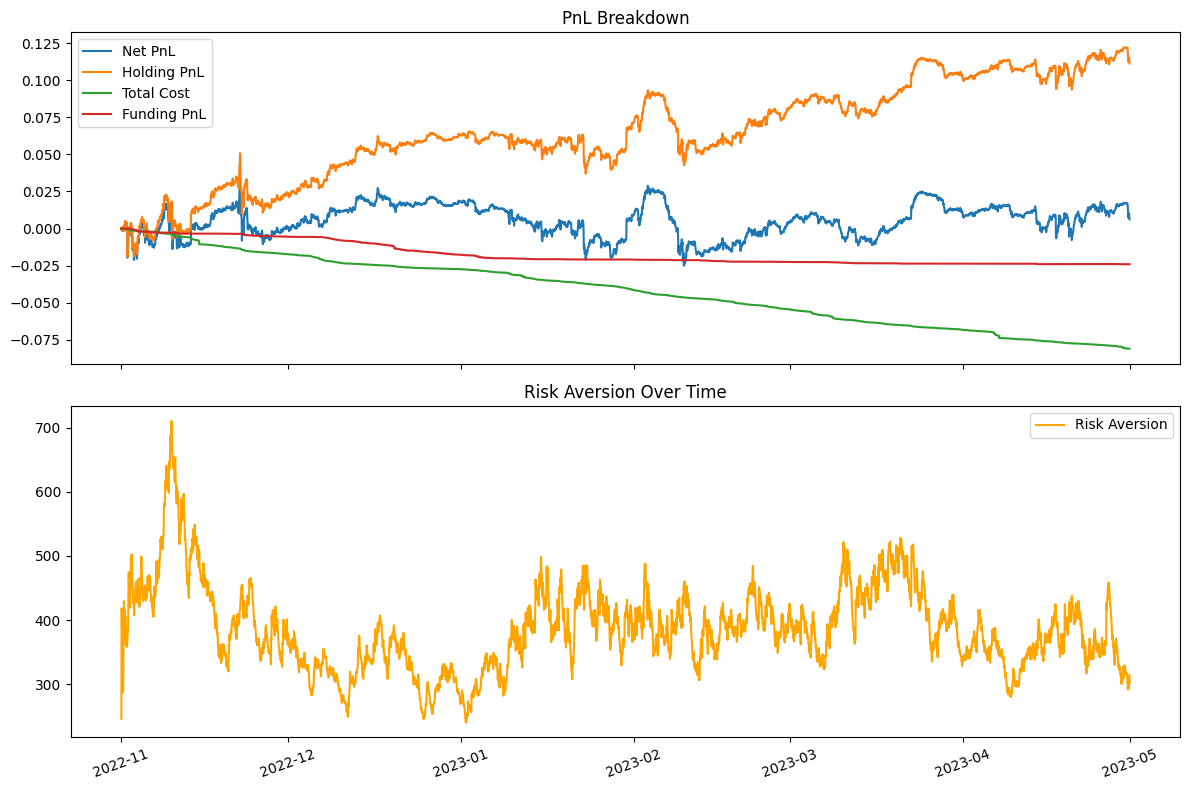

day_count                     181.000000
daily_ret_mean       (bps)      1.115486
daily_ret_std        (bps)     56.910761
daily_ret_skew       (bps)     -0.420643
daily_ret_max        (bps)    190.579609
daily_ret_min        (bps)   -242.384445
annualized_ret       (bps)    354.397171
monthly_geometic_ret (bps)     29.063974
max_drawdown         (bps)   -485.803708
annual_ret/max_drawdown         0.729507
sharpe                          0.374469
sortino                         0.469582
tot_compounded_ret   (bps)    174.199588
rolling_1yr_vol_mean (bps)           NaN
rolling_1yr_vol_min  (bps)           NaN
rolling_1yr_vol_max  (bps)           NaN
daily_ret_10th       (bps)    -54.650726
daily_ret_25th       (bps)    -22.614460
daily_ret_50th       (bps)      4.295220
daily_ret_75th       (bps)     25.264138
daily_ret_90th       (bps)     61.584912
dtype: float64
Backtest Complete!


In [35]:
max_holding = 0.1         
volume_max_turnover = 0.002
min_yearly_return = 0.3   
sparsity_penalty = 0.01
taker_fees = 0.0005    

lambda_0 = 45
alpha = 8750

sharpes = []

# with slippage
optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_yearly_return, taker_fees, True, 5, 24)
sharpe, calmar, final_equity = optimizer.backtest(1000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, True, liquidity)

# without slippage
#optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_yearly_return, taker_fees, False, 5)
#sharpe, calmar, final_equity = optimizer.backtest(10000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, True)

In [ ]:
max_holding = 0.1
volume_max_turnover = 0.01
min_yearly_return = 0.3   
taker_fees = 0.0005

# Bayesian Hyperparameter tuning
def objective(trial):
    recovery_rate = trial.suggest_float('recovery_rate', 0, 5)
    lambda_0 = trial.suggest_float('lambda_0', 0, 50)
    alpha = trial.suggest_float('alpha', 0, 10000)
    sparsity_penalty = trial.suggest_float('sparsity_penalty', 0, 0.1)

    mean_error_df = index_prices.copy()
    mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
    mean_error_df = mean_error_df[["TICKER", "return"]]

    mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
    mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                                np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                                np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

    absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
    recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
    recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

    new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)


    # with slippage
    optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_yearly_return, taker_fees, True, 5, 24)
    sharpe, calmar, final_equity = optimizer.backtest(1000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, False, liquidity)

    # without slippage
    #optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_yearly_return, taker_fees, False, 5)
    #sharpe, calmar, final_equity = optimizer.backtest(10000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, False)

    return 0.4 * sharpe/3 + 0.6*calmar/6


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

[I 2025-07-25 04:52:09,200] A new study created in memory with name: no-name-aab75b8f-2951-428f-8ce7-a82e7571624d


In [353]:
# Continue Optimization
study.optimize(objective, n_trials=500)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

[W 2025-07-20 22:19:42,496] Trial 15 failed with parameters: {'recovery_rate': 1.45042134169503, 'lambda_0': 40.48528572474403, 'alpha': 1880.474339250478, 'lambda_turnover': 0.11829077301930505} because of the following error: SolverError("Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.").
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2160254/3452866424.py", line 32, in objective
    sharpe, calmar, final_equity = optimizer.backtest(10000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, False, liquidity)
  File "/home/ubuntu/Desktop/Optimizer Project/Optimizer.py", line 597, in backtest
    portfolio_holdings, status = self.optimize(
  File "/home/ubuntu/Desktop/Optimizer Project/Optimizer.py", line 368, in optim

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

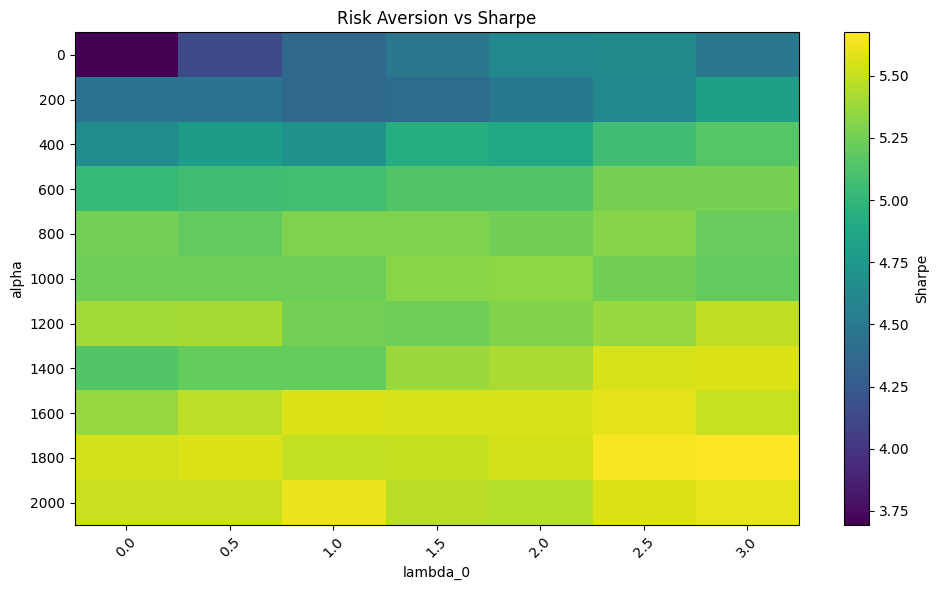

In [141]:
lambda_vals = np.arange(0, 3.5, 0.5)  
alpha_vals = np.arange(0, 2200, 200)

a = np.array(lambdas[:-30])
b = np.array(alphas[:-30])
c = np.array(sharpes[:-30])

c_matrix = np.array(c).reshape(len(lambda_vals), len(alpha_vals)).T

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(c_matrix, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(lambda_vals)))
ax.set_yticks(np.arange(len(alpha_vals)))
ax.set_xticklabels(np.round(lambda_vals, 2))
ax.set_yticklabels(alpha_vals)
ax.set_xlabel('lambda_0')
ax.set_ylabel('alpha')
ax.set_title('Risk Aversion vs Sharpe')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Sharpe')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()